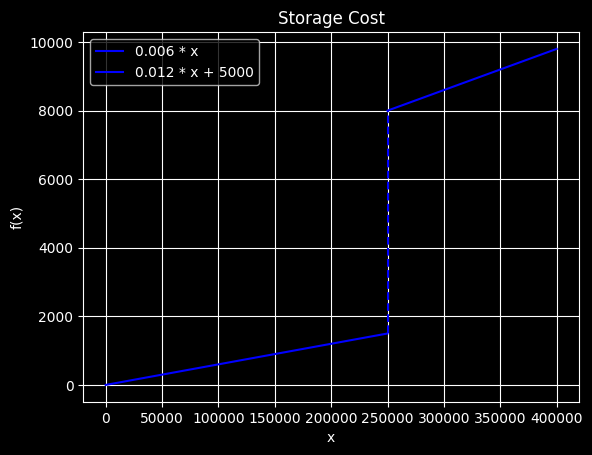

In [2]:
import dataclasses
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt

def storage_cost(x):
    if x < 0:
        return 0
    elif x < 250e3:
        return 0.006 * x
    else:
        return 0.012 * x + 5000

x1 = np.linspace(0, 250e3-1, 400)
x2 = np.linspace(250e3, 400e3, 400)
y1 = [storage_cost(xi) for xi in x1]
y2 = [storage_cost(xi) for xi in x2]
plt.style.use("dark_background")
plt.plot(x1, y1, label="0.006 * x", color="blue")
plt.plot(x2, y2, label="0.012 * x + 5000", color="blue")
plt.plot([250e3, 250e3], [storage_cost(250e3-1), storage_cost(250e3)],linestyle='dashed', color='blue')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Storage Cost")
plt.legend()
plt.grid()
plt.savefig("docs/images/storage_cost.png", format="png", transparent=True)


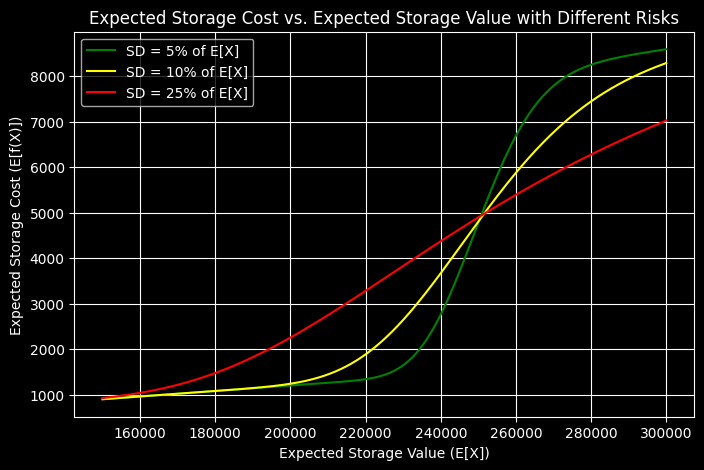

In [3]:
from scipy.stats import norm

expected_values = np.linspace(150e3, 300e3, 1_000)
sd_percentages = [0.05, 0.10, 0.25]  # Standard deviation as percentage of expected_storage
threshold = 250000  # Threshold value for storage cost
storage_costs = {sd_pct: [] for sd_pct in sd_percentages}

# Compute expected storage costs for each expected value and standard deviation
for e in expected_values:
    for sd_pct in sd_percentages:
        sd = e * sd_pct  # Compute standard deviation
        z = (threshold - e) / sd  # Compute z-score
        Phi_z = norm.cdf(z)  # Probability of being below threshold
        one_minus_Phi_z = 1 - Phi_z  # Probability of being above threshold
        phi_z = norm.pdf(z)  # PDF at z

        # Compute expected values given truncation
        E_X_below = e - sd * (phi_z / Phi_z) if Phi_z > 0 else e  # Avoid division by zero
        E_X_above = e + sd * (phi_z / one_minus_Phi_z) if one_minus_Phi_z > 0 else e

        # Compute expected storage cost
        E_f_X = (0.006 * E_X_below * Phi_z) + ((5000 + 0.012 * E_X_above) * one_minus_Phi_z)

        # Store result
        storage_costs[sd_pct].append(E_f_X)

colors = {0.05: "green", 0.10: "yellow", 0.25: "red"}

# Plot results
plt.figure(figsize=(8, 5))
for sd_pct in sd_percentages:
    plt.plot(expected_values, storage_costs[sd_pct],color=colors[sd_pct], label=f"SD = {int(sd_pct * 100)}% of E[X]")
plt.style.use("dark_background")
plt.xlabel("Expected Storage Value (E[X])")
plt.ylabel("Expected Storage Cost (E[f(X)])")
plt.title("Expected Storage Cost vs. Expected Storage Value with Different Risks")
plt.legend()
plt.grid()
plt.show()

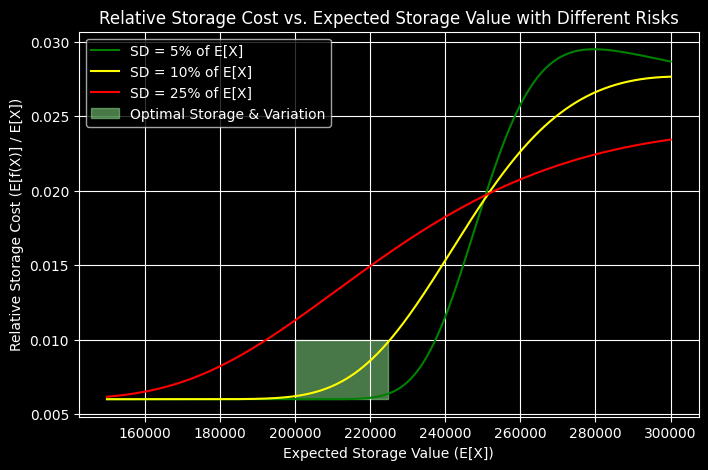

In [4]:
# Compute relative storage cost s(x) / x for each expected value and standard deviation
relative_storage_costs = {sd_pct: np.array(storage_costs[sd_pct]) / expected_values for sd_pct in sd_percentages}
goal_min, goal_max = 200000, 225000
goal_range = (expected_values >= goal_min) & (expected_values <= goal_max)

# Plot relative storage costs
plt.figure(figsize=(8, 5))
for sd_pct in sd_percentages:
    plt.plot(expected_values, relative_storage_costs[sd_pct], label=f"SD = {int(sd_pct * 100)}% of E[X]", color=colors[sd_pct])
plt.fill_between(expected_values[goal_range], 0.01, 0.006, color="lightgreen", alpha=0.5, label="Optimal Storage & Variation")
plt.style.use("dark_background")
plt.xlabel("Expected Storage Value (E[X])")
plt.ylabel("Relative Storage Cost (E[f(X)] / E[X])")
plt.title("Relative Storage Cost vs. Expected Storage Value with Different Risks")
plt.legend()
plt.grid()
plt.savefig("docs/images/relative_storage_cost_optimal.png", format="png", transparent=True)
plt.show()


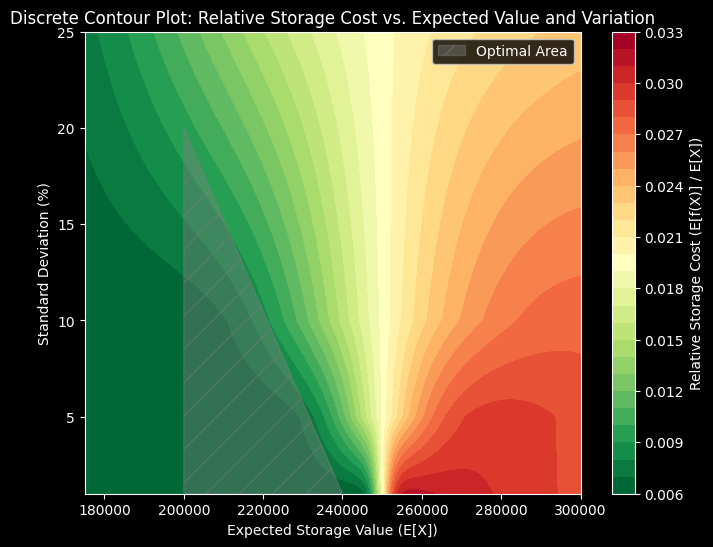

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.patches import Polygon

# 1) SETUP
expected_values = np.linspace(175e3, 300e3, 10_000)  # Expected storage values
sd_percentages = np.array([0.01, 0.05, 0.10, 0.25])    # Standard deviations (as % of E[X])
threshold = 250000                              # Threshold value for storage cost

# Create meshgrid for expected values (X-axis) and SD percentages (Y-axis)
E_mesh, sd_pct_mesh = np.meshgrid(expected_values, sd_percentages)

# 2) CALCULATE EXPECTED STORAGE COSTS FOR EACH POINT
storage_costs_mesh = np.zeros_like(E_mesh)
for i in range(E_mesh.shape[0]):
    for j in range(E_mesh.shape[1]):
        e = E_mesh[i, j]
        sd = e * sd_pct_mesh[i, j]  # Standard deviation
        z = (threshold - e) / sd    # z-score
        Phi_z = norm.cdf(z)         # Probability of X < threshold
        one_minus_Phi_z = 1 - Phi_z
        phi_z = norm.pdf(z)

        # Avoid division by zero
        E_X_below = e - sd * (phi_z / Phi_z) if Phi_z > 0 else e
        E_X_above = e + sd * (phi_z / one_minus_Phi_z) if one_minus_Phi_z > 0 else e

        # Expected storage cost
        storage_costs_mesh[i, j] = (
                0.006 * E_X_below * Phi_z
                + (5000 + 0.012 * E_X_above) * one_minus_Phi_z
        )

# 3) RELATIVE STORAGE COST = s(x) / x
relative_cost_mesh = storage_costs_mesh / E_mesh

# 4) DEFINE DISCRETE LEVELS FOR THE CONTOUR
levels = [ x / 1000 for x in range(6 ,34, 1)]

# 5) CREATE A DISCRETE COLORMAP (GREEN → YELLOW → RED), WITH EXTENDED BOUNDS Red Yellow Green Reversed
cmap = plt.get_cmap("RdYlGn_r", len(levels) - 1)

# 6) PLOT THE CONTOUR WITH FEWER, DISCRETE COLORS
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(
        E_mesh,
        sd_pct_mesh * 100,
        relative_cost_mesh,
        levels=levels,
        cmap=cmap,
)
triangle_coords = [(200000, 1), (200000, 20), (240000, 1)]
triangle = Polygon(triangle_coords, facecolor="gray", alpha=0.4,
                   edgecolor="gray", label="Optimal Area", rasterized=True, hatch="/")
ax.add_patch(triangle)
# 7) COLOR BAR & LABELS
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label("Relative Storage Cost (E[f(X)] / E[X])")
ax.set_xlabel("Expected Storage Value (E[X])")
ax.set_ylabel("Standard Deviation (%)")
ax.set_title("Discrete Contour Plot: Relative Storage Cost vs. Expected Value and Variation")
plt.style.use("dark_background")
plt.legend()
plt.savefig("docs/images/color_map_standard_deviation_expected_optimal_large.png", format="png", transparent=True)

plt.show()

print()


In [6]:
def storage_cost(expected_storage, standard_deviation_relative, threshold):
    standard_deviation = expected_storage * standard_deviation_relative
    z = (threshold - expected_storage) / standard_deviation
    Phi_z = norm.cdf(z)
    one_minus_phi_z = 1 - Phi_z
    phi_z = norm.pdf(z)

    e_x_below = expected_storage - standard_deviation * (phi_z / Phi_z) if phi_z > 0 else expected_storage
    e_x_above = expected_storage + standard_deviation * (phi_z / one_minus_phi_z) if one_minus_phi_z > 0 else expected_storage

    return (0.006 * e_x_below * Phi_z) + ((5000 + 0.012 * e_x_above) * one_minus_phi_z)


for cords in triangle_coords:
    print(cords[0], cords[1] / 100, threshold)
    print(storage_cost(cords[0], cords[1] / 100, threshold) / cords[0])

200000 0.01 250000
0.006
200000 0.2 250000
0.00949432188613934
240000 0.01 250000
0.00600041875608027


In [10]:
import pandas as pd

df = pd.read_csv("labour-machine-cost.csv", decimal=",")

In [24]:
import dataclasses

MINIMUM_SHIFTS = 1
MAXIMUM_SHIFTS = 3
SHIFT_DURATION = 60 * 8
MAX_OVERTIME = SHIFT_DURATION  / 2
MAX_DURATION = SHIFT_DURATION * 3


def round_ties_to_down(number):
    return round(number - 0.00001)

@dataclasses.dataclass
class CalculateShiftCost:
    labour_cost_1: float
    labour_cost_2: float
    labour_cost_3: float
    labour_overtime_cost: float
    fix_machine_cost: float
    var_machine_cost: float

    def calculate_required_shifts(self, required_capacity):
        rounded_shift = round_ties_to_down(required_capacity / SHIFT_DURATION)
        shifts = max(MINIMUM_SHIFTS, min(MAXIMUM_SHIFTS, rounded_shift))
        return shifts

    def calculate_overtime(self, required_capacity):
        shifts = self.calculate_required_shifts(required_capacity)
        if shifts == 3:
            return 0
        else:
            return max(0, required_capacity - shifts * SHIFT_DURATION)

    def calc_labour_cost(self, required_capacity):
        shifts = self.calculate_required_shifts(required_capacity)
        overtime = self.calculate_overtime(required_capacity)
        first_shift_cost = float(SHIFT_DURATION * self.labour_cost_1)
        second_shift_cost = float(SHIFT_DURATION * self.labour_cost_2)
        third_shift_cost = float(SHIFT_DURATION * self.labour_cost_3)

        overtime_cost = float(overtime * self.labour_overtime_cost)

        labour_cost = first_shift_cost + overtime_cost

        match shifts:
            case 2:
                labour_cost += second_shift_cost
            case 3:
                labour_cost += second_shift_cost + third_shift_cost

        return labour_cost

    def calc_labour_cost_relative(self, required_capacity):
        labour_cost_abs = self.calc_labour_cost(required_capacity)
        return labour_cost_abs / required_capacity


    def calculate_fix_machine_cost(self, required_capacity):
        shifts = self.calculate_required_shifts(required_capacity)
        overtime = self.calculate_overtime(required_capacity)

        work_time = shifts * SHIFT_DURATION + overtime

        idle_time = required_capacity - work_time

        return self.fix_machine_cost * idle_time

    def calculate_fix_machine_cost_relative(self, required_capacity):
        fix_machine_cost = self.calculate_fix_machine_cost(required_capacity)
        return fix_machine_cost / required_capacity

    def calculate_var_machine_cost(self, required_capacity):
        return self.var_machine_cost * required_capacity

    def calculate_var_machine_cost_relative(self, required_capacity):
        var_machine_cost = self.calculate_var_machine_cost(required_capacity)
        return var_machine_cost / required_capacity


first_ws = df[df["workstation"] == 1]

cost_calc = CalculateShiftCost(
        first_ws["labourCost1"].iloc[0],
        first_ws["labourCost2"].iloc[0],
        first_ws["labourCost3"].iloc[0],
        first_ws["labourOvertimeCost"].iloc[0],
        first_ws["var_machineCost"].iloc[0],
        first_ws["fix_machineCost"].iloc[0])


In [17]:
assert cost_calc.calculate_required_shifts(400) == 1
assert cost_calc.calculate_required_shifts(700) == 1
assert cost_calc.calculate_required_shifts(720) == 1
assert cost_calc.calculate_required_shifts(721) == 2
assert cost_calc.calculate_required_shifts(1000) == 2
assert cost_calc.calculate_required_shifts(10_000) == 3

In [26]:
cost_calc.calc_labour_cost(400)

216.0

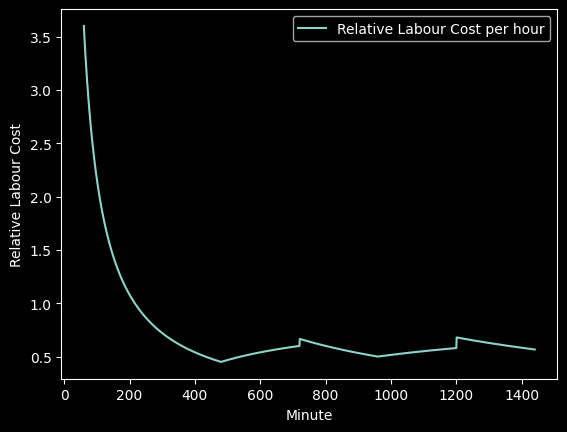

In [30]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(60, 60*24+1)
y = [cost_calc.calc_labour_cost_relative(i) for i in x]

plt.plot(x, y, label="Relative Labour Cost per hour")
plt.xlabel("Minute")
plt.ylabel("Relative Labour Cost")
plt.legend()
plt.show()


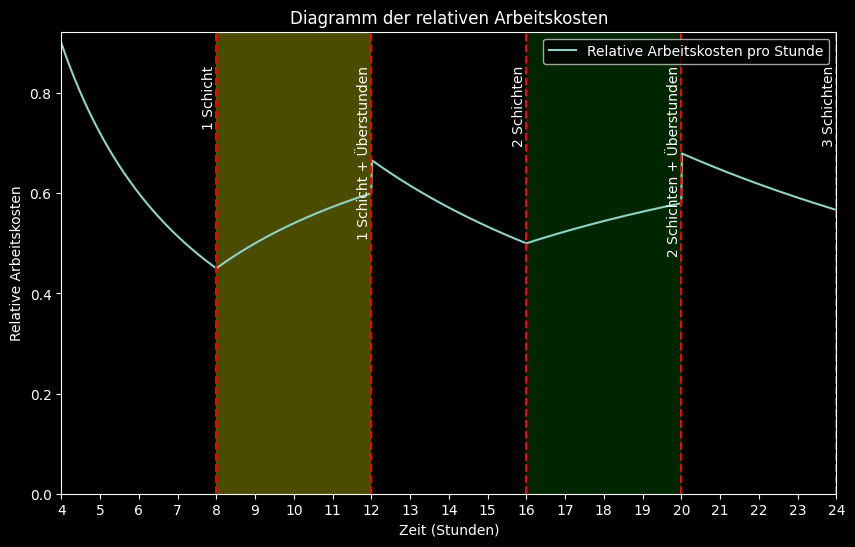

In [44]:
import matplotlib.pyplot as plt
import numpy as np

FIRST_VALUE = 60 * 4

x = np.arange(FIRST_VALUE, 60*24+1)
y = [cost_calc.calc_labour_cost_relative(i) for i in x]

plt.figure(figsize=(10,6))
plt.plot(x, y, label="Relative Arbeitskosten pro Stunde")
plt.xlabel("Zeit (Stunden)")
plt.ylabel("Relative Arbeitskosten")
plt.title("Diagramm der relativen Arbeitskosten")
plt.ylim(bottom=0)

# Markiere spezielle Bereiche:
plt.axvspan(8*60, 12*60, facecolor='yellow', alpha=0.3)  # Bereich: 1 Schicht bis 1 Schicht + Überstunden
plt.axvspan(16*60, 20*60, facecolor='green', alpha=0.3)   # Bereich: 2 Schichten bis 2 Schichten + Überstunden

shift_positions = {
    8*60: "1 Schicht",
    12*60: "1 Schicht + Überstunden",
    16*60: "2 Schichten",
    20*60: "2 Schichten + Überstunden",
    24*60: "3 Schichten"
}

y_max = max(y)
for pos, lab in shift_positions.items():
    plt.axvline(x=pos, color="red", linestyle="--")
    plt.text(pos, y_max*0.95, lab, rotation=90, verticalalignment="top", horizontalalignment="right")

plt.xlim(FIRST_VALUE, 60*24)
ticks = np.arange(FIRST_VALUE, 60*24+1, 60)
plt.xticks(ticks, [str(int(tick/60)) for tick in ticks])
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

FIRST_VALUE = 60 * 4

x = np.arange(FIRST_VALUE, 60*24+1)
y_labour = [cost_calc.calc_labour_cost_relative(i) for i in x]
y_fix = [cost_calc.calculate_fix_machine_cost_relative(i) for i in x]
y_var = [cost_calc.calculate_var_machine_cost_relative(i) for i in x]
y_total = [l + f + v for l, f, v in zip(y_labour, y_fix, y_var)]

plt.figure(figsize=(10,6))
plt.plot(x, y_labour, label="Arbeitskosten")
plt.plot(x, y_fix, label="Fixe Maschinenkosten")
plt.plot(x, y_var, label="Variable Maschinenkosten")
plt.plot(x, y_total, label="Gesamtkosten", linestyle="--", color="black")

plt.xlabel("Zeit (Stunden)")
plt.ylabel("Relative Kosten")
plt.title("Diagramm der relativen Kosten")
plt.ylim(bottom=0)

# Markiere spezielle Bereiche:
plt.axvspan(8*60, 12*60, facecolor='yellow', alpha=0.3)  # 1 Schicht bis 1 Schicht + Überstunden
plt.axvspan(16*60, 20*60, facecolor='green', alpha=0.3)   # 2 Schichten bis 2 Schichten + Überstunden

shift_positions = {
    8*60: "1 Schicht",
    12*60: "1 Schicht + Überstunden",
    16*60: "2 Schichten",
    20*60: "2 Schichten + Überstunden",
    24*60: "3 Schichten"
}

y_max = max(max(y_labour), max(y_fix), max(y_var), max(y_total))
for pos, lab in shift_positions.items():
    plt.axvline(x=pos, color="red", linestyle="--")
    plt.text(pos, y_max*0.95, lab, rotation=90, verticalalignment="top", horizontalalignment="right")

plt.xlim(FIRST_VALUE, 60*24)
ticks = np.arange(FIRST_VALUE, 60*24+1, 60)
plt.xticks(ticks, [str(int(tick/60)) for tick in ticks])
plt.legend()
plt.show()
